# Forcasting with LSTM on NGA time serie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
path_1 = "../Data/test_st.csv"
path_2 = "../Data/extaction_missing_data.csv"

df = pd.read_csv(path_1)
#df2 = pd.read_csv(path_2) 

In [3]:
df

,value_created_at,measure_id,point_id,NGA,NGV,K,VCC_g,VC_g
0,2023-06-24 15:05:48,12870679,232710,0.10832,2.77359,1.891347,0.49635,0.41004
1,2023-06-24 15:22:51,12870678,232710,0.10783,3.13995,1.896530,0.48180,0.42522
2,2023-06-24 15:50:00,12870677,232710,0.10815,2.66659,1.887733,0.48101,0.40710
3,2023-06-24 15:55:00,12870676,232710,0.10708,2.65100,1.901864,0.48632,0.40771
4,2023-06-24 16:00:00,12870675,232710,0.10750,2.55173,1.898690,0.49191,0.42289
...,...,...,...,...,...,...,...,...
5699,2024-03-01 06:40:00,21130040,232710,0.54927,4.42352,4.068230,9.18245,4.87565
5700,2024-03-01 07:40:00,21132241,232710,0.52915,4.16160,4.259252,8.98788,5.14323
5701,2024-03-01 08:40:00,21134403,232710,0.55540,4.46625,4.059374,8.60813,4.33526
5702,2024-03-01 09:40:00,21136658,232710,0.50074,4.34932,4.110944,7.49714,3.75781


In [4]:
df2

,Unnamed: 0,value_created_at,measure_id,NGA,NGV,K,VCC_g,VC_g
0,0,2022-01-15 21:08:32,4055996,0.230,0.420,0.000000,0.000000,0.000000
1,1,2022-01-15 21:25:21,4056494,0.230,0.390,0.000000,0.000000,0.000000
2,2,2022-01-16 01:25:21,4059012,0.240,0.440,0.000000,0.000000,0.000000
3,3,2022-01-16 05:25:21,4061956,0.240,0.420,0.000000,0.000000,0.000000
4,4,2022-01-16 09:25:21,4064764,0.240,0.430,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
9729,9729,2024-08-12 22:57:28,28098744,0.413,0.471,4.117731,5.701956,2.880685
9730,9730,2024-08-13 00:57:28,28102034,0.410,0.500,4.170659,5.707357,3.037322
9731,9731,2024-08-13 02:57:28,28105174,0.418,0.508,4.137773,5.385080,2.833874
9732,9732,2024-08-13 04:57:28,28108468,0.415,0.532,4.069019,5.228443,2.776260


In [5]:
df.index = pd.to_datetime(df['value_created_at'])
df2.index = pd.to_datetime(df2['value_created_at'])

In [6]:
df

,value_created_at,measure_id,point_id,NGA,NGV,K,VCC_g,VC_g
value_created_at,,,,,,,,
2023-06-24 15:05:48,2023-06-24 15:05:48,12870679,232710,0.10832,2.77359,1.891347,0.49635,0.41004
2023-06-24 15:22:51,2023-06-24 15:22:51,12870678,232710,0.10783,3.13995,1.896530,0.48180,0.42522
2023-06-24 15:50:00,2023-06-24 15:50:00,12870677,232710,0.10815,2.66659,1.887733,0.48101,0.40710
2023-06-24 15:55:00,2023-06-24 15:55:00,12870676,232710,0.10708,2.65100,1.901864,0.48632,0.40771
2023-06-24 16:00:00,2023-06-24 16:00:00,12870675,232710,0.10750,2.55173,1.898690,0.49191,0.42289
...,...,...,...,...,...,...,...,...
2024-03-01 06:40:00,2024-03-01 06:40:00,21130040,232710,0.54927,4.42352,4.068230,9.18245,4.87565
2024-03-01 07:40:00,2024-03-01 07:40:00,21132241,232710,0.52915,4.16160,4.259252,8.98788,5.14323
2024-03-01 08:40:00,2024-03-01 08:40:00,21134403,232710,0.55540,4.46625,4.059374,8.60813,4.33526


In [7]:
df2

,Unnamed: 0,value_created_at,measure_id,NGA,NGV,K,VCC_g,VC_g
value_created_at,,,,,,,,
2022-01-15 21:08:32,0,2022-01-15 21:08:32,4055996,0.230,0.420,0.000000,0.000000,0.000000
2022-01-15 21:25:21,1,2022-01-15 21:25:21,4056494,0.230,0.390,0.000000,0.000000,0.000000
2022-01-16 01:25:21,2,2022-01-16 01:25:21,4059012,0.240,0.440,0.000000,0.000000,0.000000
2022-01-16 05:25:21,3,2022-01-16 05:25:21,4061956,0.240,0.420,0.000000,0.000000,0.000000
2022-01-16 09:25:21,4,2022-01-16 09:25:21,4064764,0.240,0.430,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-08-12 22:57:28,9729,2024-08-12 22:57:28,28098744,0.413,0.471,4.117731,5.701956,2.880685
2024-08-13 00:57:28,9730,2024-08-13 00:57:28,28102034,0.410,0.500,4.170659,5.707357,3.037322
2024-08-13 02:57:28,9731,2024-08-13 02:57:28,28105174,0.418,0.508,4.137773,5.385080,2.833874


In [8]:
nga = df['NGA']
nga2 = df2['NGA']

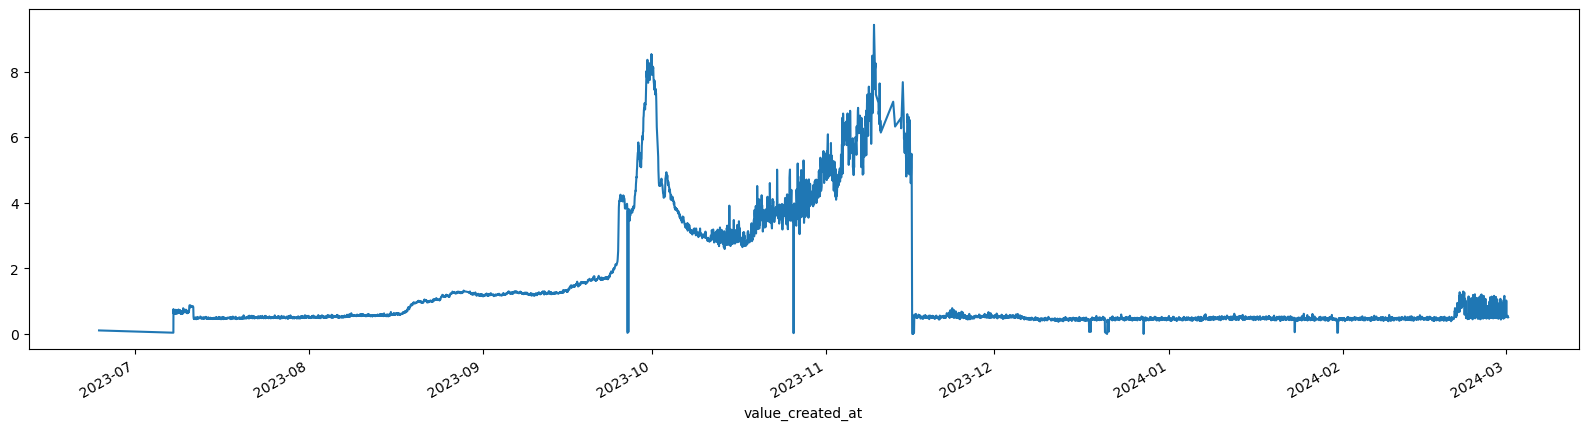

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))
nga.plot();

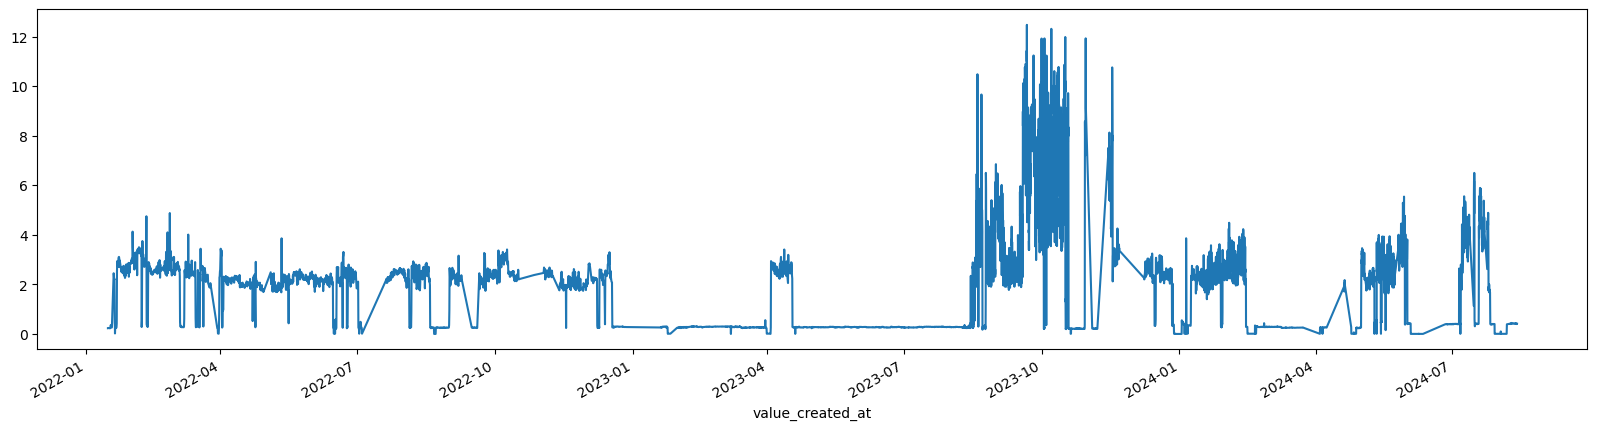

In [10]:
fig, ax = plt.subplots(figsize=(20, 5))
nga2.plot();

In [11]:
nga.index

DatetimeIndex(['2023-06-24 15:05:48', '2023-06-24 15:22:51',
               '2023-06-24 15:50:00', '2023-06-24 15:55:00',
               '2023-06-24 16:00:00', '2023-06-24 16:05:00',
               '2023-06-24 16:10:00', '2023-06-24 16:20:00',
               '2023-06-24 16:30:00', '2023-07-07 20:37:52',
               ...
               '2024-03-01 01:40:00', '2024-03-01 02:40:00',
               '2024-03-01 03:40:00', '2024-03-01 04:40:00',
               '2024-03-01 05:40:00', '2024-03-01 06:40:00',
               '2024-03-01 07:40:00', '2024-03-01 08:40:00',
               '2024-03-01 09:40:00', '2024-03-01 10:40:00'],
              dtype='datetime64[ns]', name='value_created_at', length=5704, freq=None)

In [12]:
nga2.index

DatetimeIndex(['2022-01-15 21:08:32', '2022-01-15 21:25:21',
               '2022-01-16 01:25:21', '2022-01-16 05:25:21',
               '2022-01-16 09:25:21', '2022-01-16 13:25:21',
               '2022-01-16 17:25:21', '2022-01-16 21:25:21',
               '2022-01-17 01:25:21', '2022-01-17 05:25:21',
               ...
               '2024-08-12 15:24:56', '2024-08-12 16:57:27',
               '2024-08-12 17:02:31', '2024-08-12 18:57:28',
               '2024-08-12 20:57:28', '2024-08-12 22:57:28',
               '2024-08-13 00:57:28', '2024-08-13 02:57:28',
               '2024-08-13 04:57:28', '2024-08-13 06:57:28'],
              dtype='datetime64[ns]', name='value_created_at', length=9734, freq=None)

In [13]:
diff = np.diff(nga.index)/1e9
diff = diff.astype(np.int32)
diff

array([1023, 1629,  300, ..., 3600, 3600, 3600])

In [14]:
diff2 = np.diff(nga2.index)/1e9
diff2 = diff2.astype(np.int32)
diff2

array([ 1009, 14400, 14400, ...,  7200,  7200,  7200])

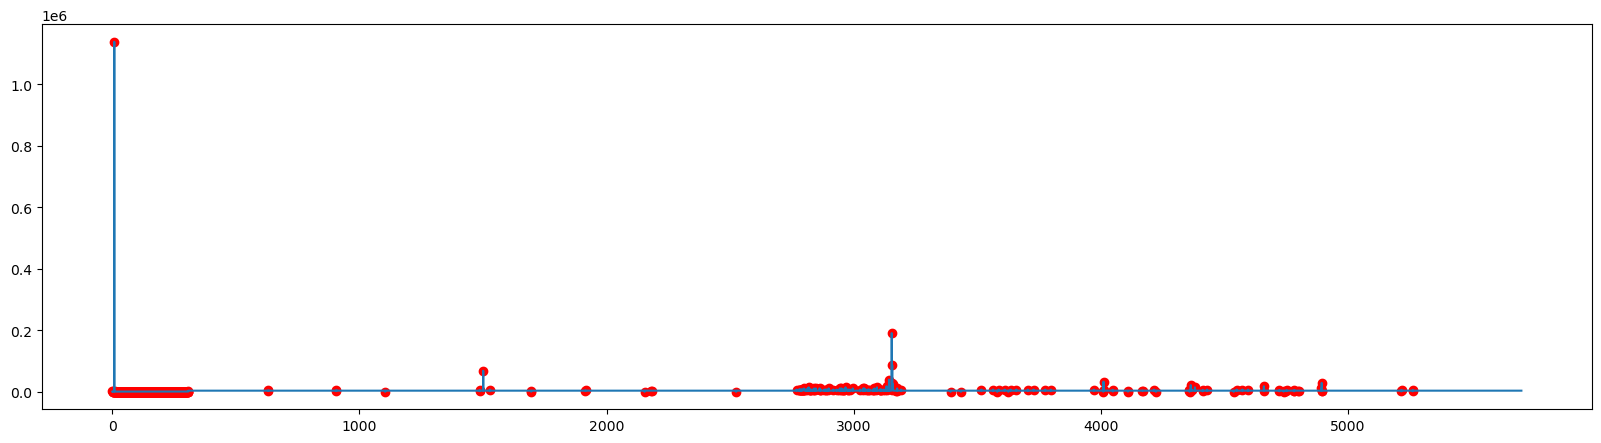

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(diff)
plt.scatter(x=np.where(diff!=3600), y=diff[diff!=3600], color='red')

(3000.0, 8000.0)

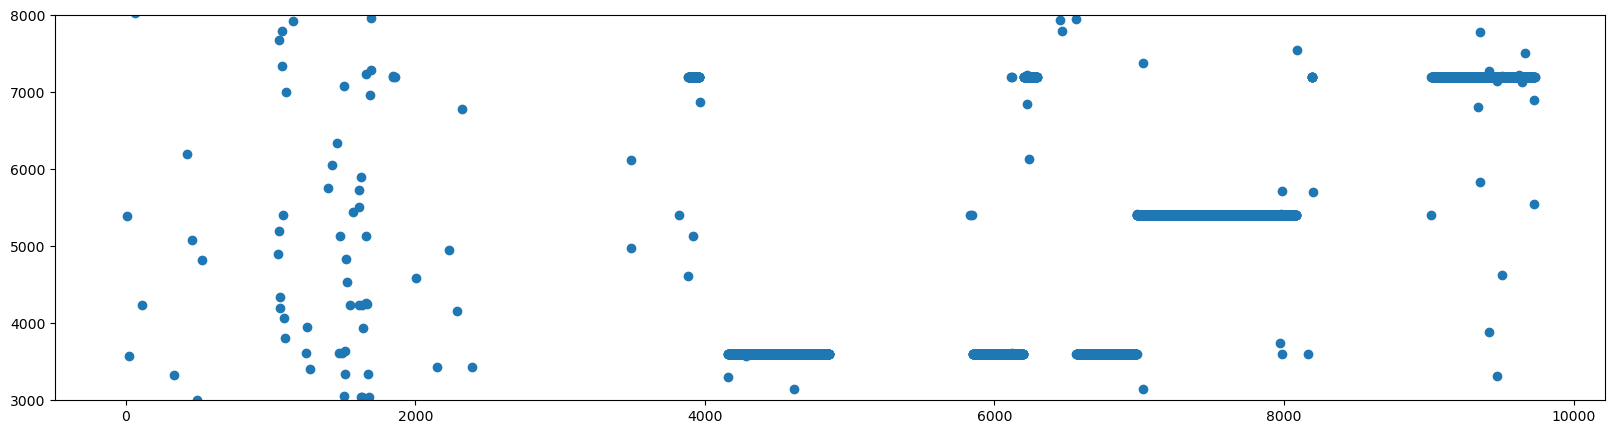

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
#plt.plot(diff2)
#plt.scatter(x=np.where(diff2!=3600), y=diff2[diff2!=3600], color='red')
plt.scatter(x=np.array(range(len(diff2))), y=diff2)
plt.ylim([3000, 8000])

In [17]:
np.median(diff2)

5400.0

<b>Remarks:</b>
- From the above plot we can see that not all points are 1-hour separated
- And inconsistencies are occuring everywhere
- Thus, we cannot have sufficient interval with 1-hour separated points
- A possible solution is make an interpolation with available points, then sample every 1 hour from the interpolation 

In [18]:
def df_to_X_y(df, window_size=5, delay=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size-delay+1):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size+delay-1]
    y.append(label)
  return np.array(X), np.array(y)

In [19]:
WINDOW_SIZE = 260
DELAY = 360
X, y = df_to_X_y(nga, WINDOW_SIZE, DELAY)
X.shape, y.shape

((5085, 260, 1), (5085,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.55, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1830, 260, 1), (1830,), (458, 260, 1), (458,), (2797, 260, 1), (2797,))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MAE
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(109,
           dropout=0.11778588671102283,
           recurrent_dropout=0.07433616828795207))
model1.add(Dense(24, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 109)            │        48,396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         2,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,061 (199.46 KB)

 Trainable params: 51,061 (199.46 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
cp1 = ModelCheckpoint('model_nga_15days.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1.646553471024582e-05))

In [23]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - loss: 4.6166 - val_loss: 6.7048
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 4.2683 - val_loss: 5.2622
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 3.5848 - val_loss: 3.8512
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.5428 - val_loss: 2.3443
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 3.0254 - val_loss: 0.8578
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 2.1716 - val_loss: 0.3743
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 2.2587 - val_loss: 0.4874
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 1.8749 - val_loss: 0.6107
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 2.0960 - val_loss: 0.7439
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 2.0361 - val_loss: 0.8642


In [24]:
from tensorflow.keras.models import load_model
model1 = load_model('model_nga_15days.keras')

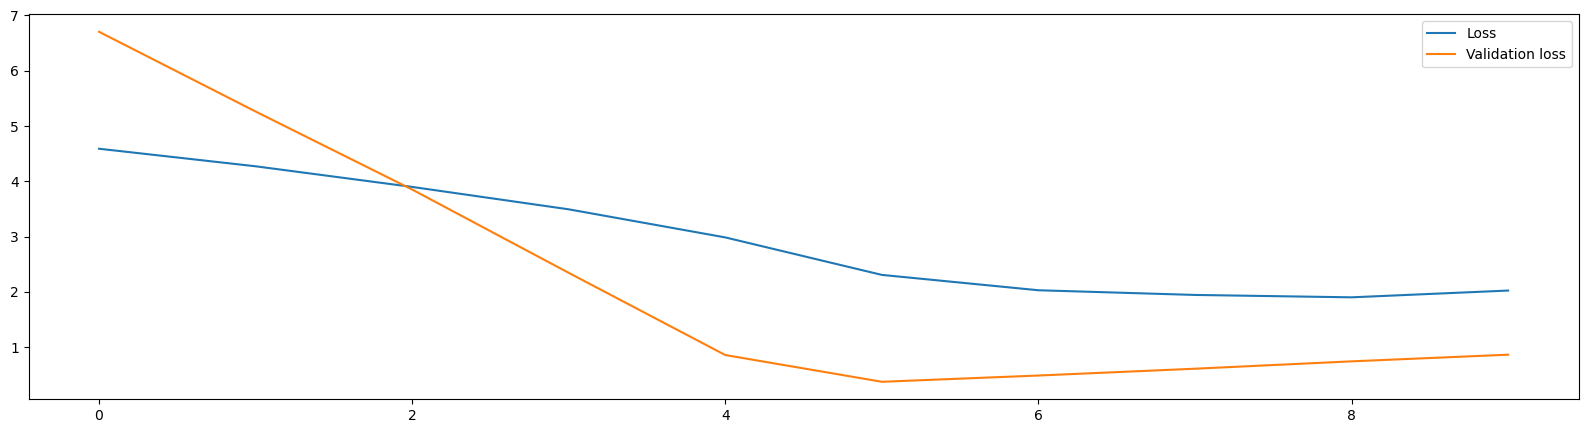

In [25]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


,Train Predictions,Actuals
0,1.156090,0.50193
1,1.159714,0.51624
2,1.164644,0.54200
3,1.169087,0.52256
4,1.174580,0.49467
...,...,...
1825,2.710721,3.34115
1826,2.711583,3.23155
1827,2.712688,3.31998
1828,2.713508,3.17047


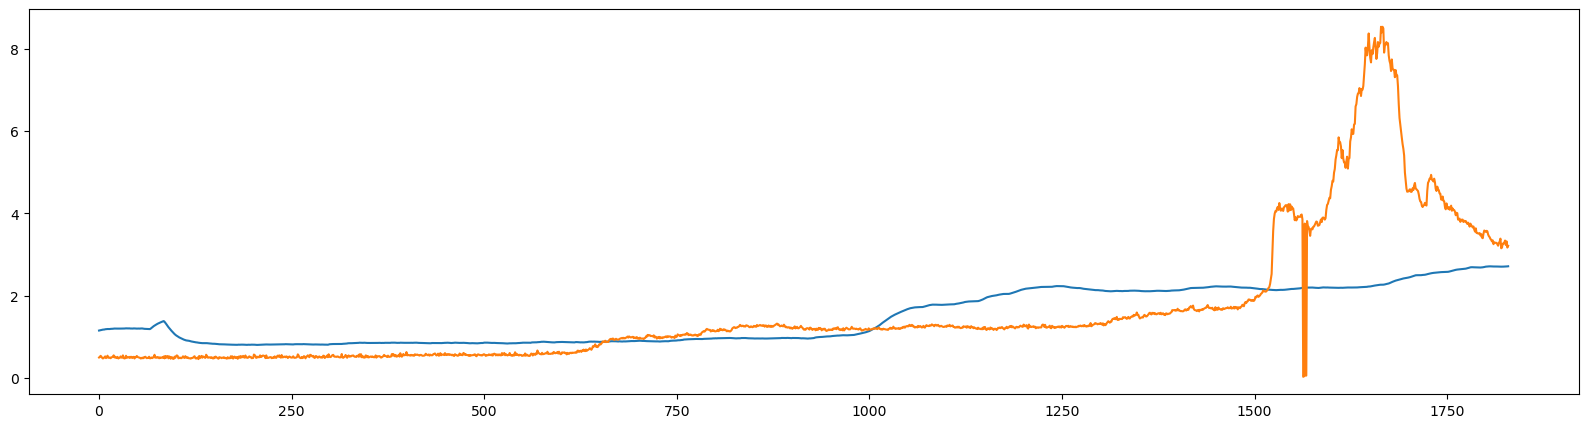

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [28]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


,Val Predictions,Actuals
0,2.716255,3.09953
1,2.717317,3.10189
2,2.717644,3.09951
3,2.719583,3.12790
4,2.719690,3.08866
...,...,...
453,3.369720,3.78056
454,3.373540,4.32566
455,3.377959,3.81661
456,3.380181,3.93936


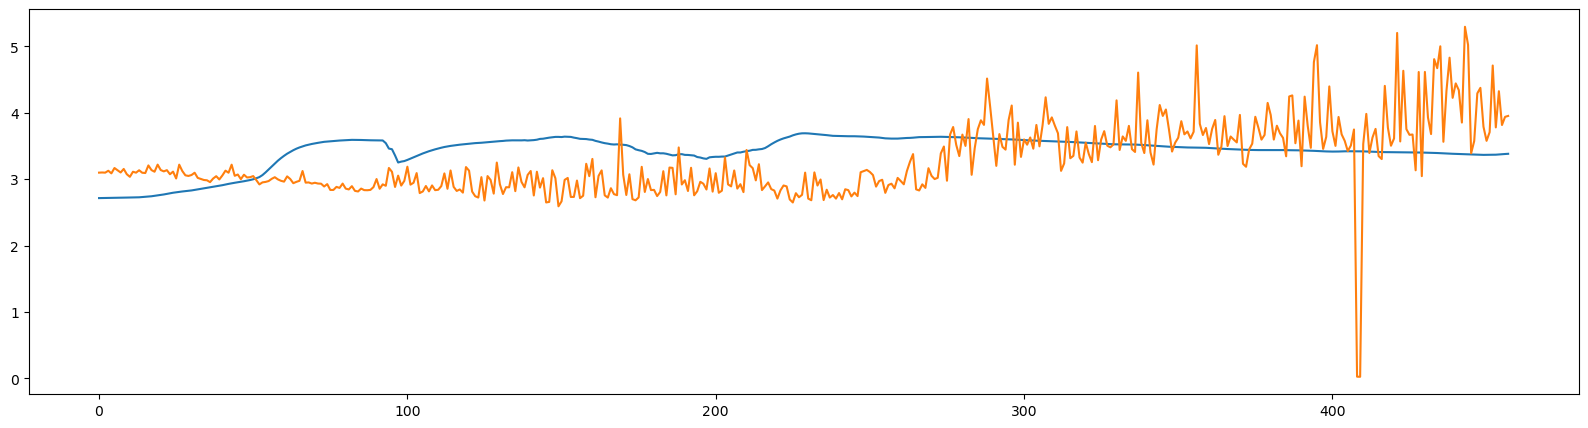

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [30]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step


,Test Predictions,Actuals
0,3.384398,4.63312
1,3.385785,3.97055
2,3.389291,4.55296
3,3.390887,3.54935
4,3.391901,4.28660
...,...,...
2792,0.808669,0.54927
2793,0.806743,0.52915
2794,0.807080,0.55540
2795,0.803935,0.50074


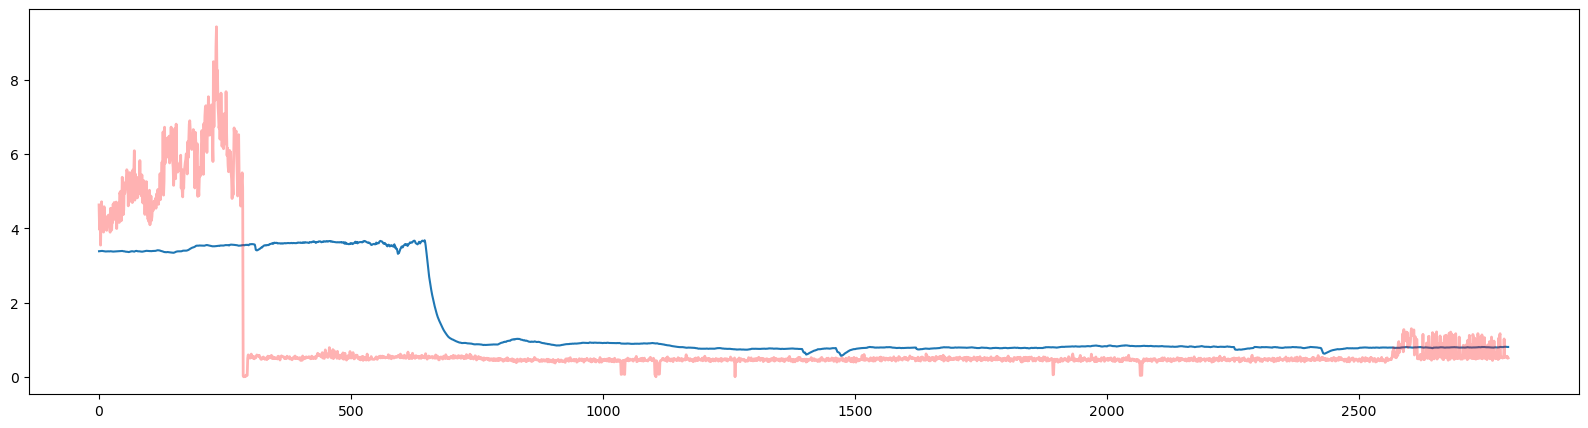

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'], linewidth=2, alpha=0.3, color='red')

In [32]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
print("Test RMSE : ", root_mean_squared_error(y_test, test_predictions))
print("Test MAE : ", mean_absolute_error(y_test, test_predictions))

Test RMSE :  1.3789269329773917
Test MAE :  0.8878552810964015
